In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.stats import pointbiserialr
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import svm, tree, naive_bayes, ensemble
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
from copy import deepcopy
from pprint import pprint
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Python/TFG')

In [ ]:
def comparePredict(prediction, testdata, should_print = True):
  """
  Compares the predicted system output data to the 'gold standard' data.
  Returns a dictionary with the recall, precision, and accuracy inside.
  Dtypes should match
  """
  tp = 0
  tn = 0
  fp = 0
  fn = 0

  for i in range(len(prediction)):
    if prediction[i] == testdata[i]:
      if prediction[i] == 1.0:
        tp+=1
      else:
        tn+=1
    else:
      if prediction[i] == 1.0:
        fp+=1
      else:
        fn+=1

  precision = tp/(tp+fp if tp+fp != 0 else 1)
  recall = tp/(tp+fn if tp+fn != 0 else 1)
  acc = (tp+tn)/(tp+tn+fp+fn)
  f1 = (2*precision*recall)/(precision+recall if precision+recall != 0 else 1)
  if should_print:
    print(f"""
          True positives = {tp-1}
          True negatives = {tn-1}
          False positives = {fp-1}
          False negatives = {fn-1}
          Precision = {precision}
          Recall = {recall}
          Accuracy = {(acc)*100}%
          F1 = {(f1)*100}%
    """)
  return {"precision" : precision, "recall" : recall, "accuracy" : acc, "f1" : f1}

def plotCorrelation(serie, n):
  fig, ax = plt.subplots()
  ax.bar(serie.index[:n], height=abs(serie).to_list()[:n], color = '#CB0236')
  ax.spines["top"].set_visible(False)
  ax.spines["right"].set_visible(False)
  ax.spines["left"].set_visible(False)
  plt.xticks(serie.index[:n], rotation=75)
  plt.show()

def plotGraph(x, y, title = None, nticks = 6, ylim_bot = None):
  nticks -= 2
  fig, ax = plt.subplots()
  ax.plot(x, y, color = '#CB0236')
  ax.set(xlabel='Rasgos', ylabel='F1', title = title)
  if ylim_bot == None:
    ax.set_ylim(bottom = min(y), top = max(y))
  else:
    ax.set_ylim(bottom = ylim_bot, top = max(y))
  ax.set_xlim(left = min(x), right = max(x))
  yticks = [ylim_bot] if ylim_bot != None else [round(min(y), 2)]
  for i in range(nticks):
    yticks.append(round(yticks[-1]+((max(y) - yticks[-1])/2.1), 2))
  yticks.append(round(max(y), 2))
  ax.set_yticks(yticks,yticks)
  ax.grid(ls = ":")
  plt.show()

def saveGraph(x, y, path : str, name : str, title = None, nticks = 6, ylim_bot = None):
  nticks -= 2
  fig, ax = plt.subplots()
  ax.plot(x, y, color = '#CB0236')
  ax.set(xlabel='Rasgos', ylabel='F1', title = title)
  if ylim_bot == None:
    ax.set_ylim(bottom = min(y), top = max(y))
  else:
    ax.set_ylim(bottom = ylim_bot, top = max(y))
  ax.set_xlim(left = min(x), right = max(x))
  yticks = [ylim_bot] if ylim_bot != None else [round(min(y), 2)]
  for i in range(nticks):
    yticks.append(round(yticks[-1]+((max(y) - yticks[-1])/2.1), 2))
  yticks.append(round(max(y), 2))
  ax.set_yticks(yticks,yticks)
  ax.grid(ls = ":")
  plt.savefig(path+"/"+name)

def plotMultiGraph(x, y : list, labels : list[str], title = None, nticks = 6, ylim_bot = None):
  """
  y = List of tuples with each tuple containing label and the list of items to plot. Dtype = list[tuple(str, list)]
  """
  nticks -= 2
  fig, ax = plt.subplots()
  for i in range(len(y)):
    ax.plot(x, y[i], label = labels[i])
  ax.legend()
  ax.set(xlabel='Rasgos', ylabel='F1', title = title)
  if ylim_bot == None:
    ax.set_ylim(bottom = np.min(np.array(y)), top = np.max(np.array(y)))
  else:
    ax.set_ylim(bottom = ylim_bot, top = np.max(np.array(y)))
  ax.set_xlim(left = min(x), right = max(x))
  yticks = [ylim_bot] if ylim_bot != None else [round(np.min(np.array(y)), 2)]
  for i in range(nticks):
    yticks.append(round(yticks[-1]+((np.max(np.array(y)) - yticks[-1])/2.1), 2))
  yticks.append(round(np.max(np.array(y)), 2))
  ax.set_yticks(yticks,yticks)
  ax.grid(ls = ":")
  plt.show()

def plotNormalMultiGraph(x, y : list, labels : list[str], title = None, ylim_bot = None):
  """
  y = List of tuples with each tuple containing label and the list of items to plot. Dtype = list[tuple(str, list)]
  """
  fig, ax = plt.subplots()
  for i in range(len(y)):
    ax.plot(x, y[i], label = labels[i])
  ax.legend()
  ax.set(xlabel='Rasgos', ylabel='F1', title = title)
  if ylim_bot == None:
    ax.set_ylim(bottom = np.min(np.array(y)), top = np.max(np.array(y)))
  else:
    ax.set_ylim(bottom = ylim_bot, top = np.max(np.array(y)))
  ax.set_xlim(left = min(x), right = max(x))
  yticks = [ylim_bot] if ylim_bot != None else [round(np.min(np.array(y)), 2)]
  i = yticks[0]+0.01
  while i <= round(np.max(np.array(y)), 2):
    yticks.append(round(i, 2))
    i+=0.01
  yticks.append(round(np.max(np.array(y)), 2))
  ax.set_yticks(yticks,yticks)
  ax.grid(ls = ":")
  plt.show()

# Process dataset

In [ ]:
!apt install openjdk-17-jdk openjdk-17-jre
!java -version

In [ ]:
!pip install stanza
!pip install textstat
!pip install language-tool-python
import stanza
stanza.download("es")
from ClassesAndFunctions import *
df = Dataset(pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Python/TFG/train.xlsx")) # This computes the features and saves them into a DataFrame
df.to_excel("/content/drive/MyDrive/Colab Notebooks/Python/TFG/train_corpus.xlsx", engine="openpyxl") # Saves the dataframe into an excel file. Check the path, as it's written to work with my drive in google colab

In [ ]:
df.avgWordsPerSentComparison

{'human': np.float64(25.461111111111112), 'gpt': np.float64(14.0)}

# Or load data from an excel file

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Python/TFG/train_corpus.xlsx', header=0, index_col=0) # Read an excel from the path. The path written to work with my drive in google colab

df = df.sample(frac=1).reset_index(drop=True) # Shuffles the dataframe

# DataFrames containing the stratified data (label 1 for AI generated and label 0 got human generated texts)
df_gpt = df[df["label"] == 1]
df_human = df[df["label"] == 0]

len(df_gpt), len(df_human)

(425, 2890)

# Correlation

In [ ]:
# This dataframe contains the name of each feature as row index and the correlation coefficients (includes p-value of point-biserial) as columns
correlations = pd.DataFrame(columns=["point biserial correlation","p-value", "mutual info"])

for col in df.columns: # Fills the dataframe with the correlation data
    if col not in ("text", "label"):
        correlations.loc[col] = list(pointbiserialr(df["label"], df[col]))+[mutual_info_classif(df[col].to_numpy().reshape((-1, 1)), df["label"], random_state= 42)[0]]

# Plots the n most correlated features in a bar graph
n = 15
plotCorrelation(correlations.sort_values(by="mutual info" ,key=lambda v: abs(v), ascending=False)["mutual info"], n)
plotCorrelation(correlations.sort_values(by="point biserial correlation" ,key=lambda v: abs(v), ascending=False)["point biserial correlation"], n)

# Model

Each model in the 'models' list is tested and for each of these each iteration in the nested loop the features used by the model are reduced by one (from the one with the lowest correlation to the one with the highest). Then the iteration of the loop, the list of the features used, the evaluation metrics of the model and a deep copy of the model object are saved as a tuple into a dictionary, which has the models tested as keys and the list of tuples as values. Thus the optimal set of features can be retrieved from the tuple with the highest F1 score.

In [ ]:
# The order in which the features will be removed in order to minimize noise
#order_by_coefficient = "point biserial correlation"
order_by_coefficient = "mutual info"
feature_cols = correlations.sort_values(by=order_by_coefficient ,key=lambda v: abs(v), ascending=False)[order_by_coefficient].index

In [ ]:
maxiters = 100000 #Max iterations for the logistic regression and Support Vector Classification models

# List with the models that will be tested
models = (svm.SVC(max_iter=maxiters), LogisticRegression(max_iter=maxiters), tree.DecisionTreeClassifier(), ensemble.RandomForestClassifier(), ensemble.AdaBoostClassifier(), ensemble.GradientBoostingClassifier())

# This Dictionary will contain the model name as keys and a list of tuples as values.
# Each tuple contains the number of features that have been removed in index 0, the list of features used in index 1, the evaluation metrics in index 2
# and a deep copy of the model in index 3, which will be used later
models_eval = dict()

for model in models:
  for i in range(len(feature_cols)):
    # Generate train and test data. The data is sampled in a stratified way, taking the same proportion of each label.
    x_train = np.array(df_gpt[feature_cols[:len(feature_cols)-i]][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human[feature_cols[:len(feature_cols)-i]][:int(0.7*len(df_human))].to_numpy().tolist())
    y_train = np.array(df_gpt["label"][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human["label"][:int(0.7*len(df_human))].to_numpy().tolist())
    x_test  = np.array(df_gpt[feature_cols[:len(feature_cols)-i]][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human[feature_cols[:len(feature_cols)-i]][int(0.7*len(df_human)):].to_numpy().tolist())
    y_test  = np.array(df_gpt["label"][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human["label"][int(0.7*len(df_human)):].to_numpy().tolist())
    model.fit(x_train, y_train) # Model training
    y_prediction = model.predict(x_test) # Model prediction for evaluation
    if type(model).__name__ in models_eval.keys(): # Add the features used, evaluation metrics, and deep copy of the model to the dict
      models_eval[type(model).__name__].append((i, list(feature_cols[:len(feature_cols)-i]), comparePredict(y_prediction, y_test, False), deepcopy(model)))
    else: # Create the key if the name of the model hasn't been found
      models_eval[type(model).__name__] = [(i, list(feature_cols[:len(feature_cols)-i]), comparePredict(y_prediction, y_test, False), deepcopy(model))]

In [ ]:
best_model = () # Best model used (the deep copy of the model), should point to the index 3 of the tuple
best_f1 = 0 # Here the tuple of the best performing model will be stored
scores = []
for k in models_eval.keys():
  highest = max(models_eval[k], key=lambda x: x[2]["f1"])
  scores.append(highest[2]["f1"])
  print(k, ":", max(models_eval[k], key=lambda x: x[2]["f1"])[2]["f1"])
  if isinstance(best_f1, int) or highest[2]["f1"] > best_f1[2]["f1"]:
    best_f1=highest
    best_model = best_f1[3]

SVC : 0.9070631970260223
LogisticRegression : 0.9111969111969112
DecisionTreeClassifier : 0.9534883720930233
RandomForestClassifier : 0.9765625
AdaBoostClassifier : 0.9647058823529412
GradientBoostingClassifier : 0.9725490196078432


In [ ]:
print(f"The model that performed best was {type(best_model).__name__} with an F1 score of {best_f1[2]['f1']} using the following features: \n{best_f1[1]}\nFor a total of {len(best_f1[1])} features.")
print("Its evaluation metrics for language model generated label are:")
for k, v in best_f1[2].items():
  print(f"\t{k}: {v}")
print("For the human written label the metrics are:")
best_prediction_class0 = [0 if i==1 else 1 for i in best_model.predict(np.array(df_gpt[best_f1[1]][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human[best_f1[1]][int(0.7*len(df_human)):].to_numpy().tolist()))]
for k, v in comparePredict(best_prediction_class0, [0 if i == 1 else 1 for i in y_test], False).items():
  print(f"\t{k}: {v}")

The model that performed best was RandomForestClassifier with an F1 score of 0.9763779527559054 using the following features: 
['words', 'avgWordDensity', 'Grammar errors', '.', 'avgWordsPerSent', 'Lexical diversity', 'sentences', 'CONJ+ADJ', 'No explicit subject', 'obl-Verb', 'Subject-Verb', ',', 'F. Huerta readability', 'nSentsge34Words', 'countAUX', 'nSentsle11Words', 'Object-Verb', 'CONJ+ADV', 'TTR', 'countNOUN', 'PRON+VERB', 'countADJ', 'Verb-Object', 'Lexical density', 'wordCharCount', 'countCCONJ', 'countVERB', 'G. Polini', 'countSCONJ', 'Verb-Subject', 'countPRON', 'countADV', 'CONJ+NOUN', 'countPROPN', 'countADP', 'NOUN+VERB', 'CONJ+VERB', 'countNUM', 'Crawford score', '!', '-', ')', 'Comparatives', '¡', 'Superlatives', '(', 'ADJ+VERB']
For a total of 47 features.
Its evaluation metrics for language model generated label are:
	precision: 0.9841269841269841
	recall: 0.96875
	accuracy: 0.9939759036144579
	f1: 0.9763779527559054
For the human written label the metrics are:
	preci

In [ ]:
print("Full dataset prediction (I know this is wrong but I like to see high numbers): ")
comparePredict(best_model.predict(df[best_f1[1]].to_numpy()), df["label"].to_numpy())

Full dataset prediction (I know this is wrong but I like to see high numbers): 

          True positives = 420
          True negatives = 2887
          False positives = 1
          False negatives = 3
          Precision = 0.9952718676122931
          Recall = 0.9905882352941177
          Accuracy = 99.81900452488688%
          F1 = 99.29245283018868%
    


{'precision': 0.9952718676122931,
 'recall': 0.9905882352941177,
 'accuracy': 0.9981900452488688,
 'f1': 0.9929245283018868}

# Average best performing model

This next model uses the overall best performing algorithm (Random forest) and the average number of features (41) when that algorithm is the best performing.

In [ ]:
order_by_coefficient = "point biserial correlation"
feature_cols = correlations.sort_values(by=order_by_coefficient ,key=lambda v: abs(v), ascending=False)[order_by_coefficient].index
final_model = ensemble.GradientBoostingClassifier()
nfeatures = 29
x_train = np.array(df_gpt[feature_cols[:nfeatures]][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human[feature_cols[:nfeatures]][:int(0.7*len(df_human))].to_numpy().tolist())
y_train = np.array(df_gpt["label"][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human["label"][:int(0.7*len(df_human))].to_numpy().tolist())
x_test  = np.array(df_gpt[feature_cols[:nfeatures]][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human[feature_cols[:nfeatures]][int(0.7*len(df_human)):].to_numpy().tolist())
y_test  = np.array(df_gpt["label"][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human["label"][int(0.7*len(df_human)):].to_numpy().tolist())
final_model.fit(x_train, y_train)
y_prediction = final_model.predict(x_test)
comparePredict(y_prediction, y_test)


          True positives = 122
          True negatives = 861
          False positives = 5
          False negatives = 4
          Precision = 0.9534883720930233
          Recall = 0.9609375
          Accuracy = 98.89558232931726%
          F1 = 95.71984435797667%
    


{'precision': 0.9534883720930233,
 'recall': 0.9609375,
 'accuracy': 0.9889558232931727,
 'f1': 0.9571984435797667}

# Save Model

In [ ]:
import pickle
# Save the model into a pickle file
with open('Classifier.pkl','wb') as f:
    pickle.dump(best_model,f)

# Testing on test corpus

## Process the raw corpus

In [ ]:
df_test = Dataset(pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Python/TFG/test.xlsx")) # This computes the features and saves them into a DataFrame
df_test.to_excel("/content/drive/MyDrive/Colab Notebooks/Python/TFG/test_corpus.xlsx", engine="openpyxl") # Saves the dataframe into an excel file. Check the path, as it's written to work with my drive in google colab

## Or load from a xlsx

In [ ]:
df_test = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Python/TFG/test_corpus.xlsx', header=0, index_col=0) # Read an excel from the path. The path written to work with my drive in google colab
len(df_test)

0

In [ ]:
x_test  = df_test[feature_cols[:nfeatures]][:].to_numpy()
y_test  = df_test["label"][:].to_numpy()
y_prediction = final_model.predict(x_test)
comparePredict(y_prediction, y_test)

# Everything below this is for testing purposes, to make plots or export info to excel

Average words per sentence in human labeled texts and gpt labeled texts
Human mean:  33.438975870963965 	Human standard deviation:  26.709412959371907 	Human median:  24.5
GPT mean:  15.655225957049488 	GPT standard deviation:  2.3549771709734277 	GPT median:  15.33333333333333


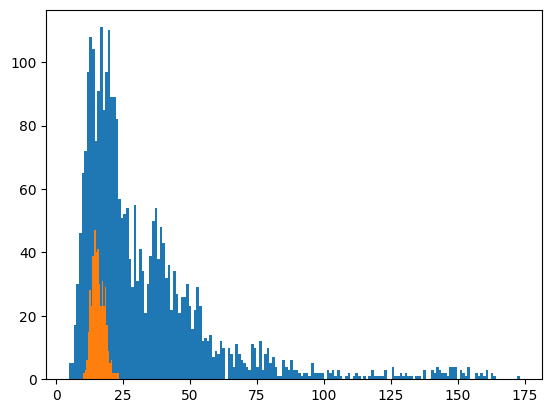

In [ ]:
avgWordsPerSentComparison = {
            'human': [df["avgWordsPerSent"][i] for i in range(len(df["label"])) if df["label"][i] == 0],
            'gpt': [df["avgWordsPerSent"][i] for i in range(len(df["label"])) if df["label"][i] == 1]
        }
plt.hist(avgWordsPerSentComparison['human'], bins=int(max(avgWordsPerSentComparison['human'])))
plt.hist(avgWordsPerSentComparison['gpt'], int(max(avgWordsPerSentComparison['gpt'])))
print("Average words per sentence in human labeled texts and gpt labeled texts")
print("Human mean: ", np.mean(avgWordsPerSentComparison['human']), "\tHuman standard deviation: ", np.std(avgWordsPerSentComparison['human']), "\tHuman median: ", np.median(avgWordsPerSentComparison['human']))
print("GPT mean: ", np.mean(avgWordsPerSentComparison['gpt']), "\tGPT standard deviation: ", np.std(avgWordsPerSentComparison['gpt']), "\tGPT median: ", np.median(avgWordsPerSentComparison['gpt']))

In [ ]:
drive.mount('/content/drive', force_remount=True)
# Generates one excel file for each algorithm in "models" with the number of features as columns and the iteration as rows. It's executed 40 times and it writes to the excel the F1 score.
# This is done for both the features ordered by point biserial and mutual info
iterations = 40
lim = 0.85
best_perf = {"point biserial correlation" : {}, "mutual info" : {}}
for coef in ("point biserial correlation", "mutual info"):
  feature_cols = correlations.sort_values(by=coef ,key=lambda v: abs(v), ascending=False)[order_by_coefficient].index
  maxiters = 100000 #Max iterations for the logistic regression and Support Vector Classification models
  models = (svm.SVC(max_iter=maxiters), LogisticRegression(max_iter=maxiters), tree.DecisionTreeClassifier(), ensemble.RandomForestClassifier(), ensemble.AdaBoostClassifier(), ensemble.GradientBoostingClassifier())
  for m in models:
    models_eval = pd.DataFrame(columns=[i for i in range(1, len(feature_cols))], index=[i for i in range(iterations)])
    model = None
    for num in range(iterations):
      df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Python/TFG/train_corpus.xlsx', header=0, index_col=0) # Read an excel from the path. The path written to work with my drive in google colab

      df = df.sample(frac=1).reset_index(drop=True) # Shuffles the dataframe

      # DataFrames containing the stratified data (label 1 for AI generated and label 0 got human generated texts)
      df_gpt = df[df["label"] == 1]
      df_human = df[df["label"] == 0]
      for i in range(len(feature_cols)):
        model = deepcopy(m)
        # Generate train and test data. The data is sampled in a stratified way, taking the same proportion of each label.
        x_train = np.array(df_gpt[feature_cols[:len(feature_cols)-i]][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human[feature_cols[:len(feature_cols)-i]][:int(0.7*len(df_human))].to_numpy().tolist())
        y_train = np.array(df_gpt["label"][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human["label"][:int(0.7*len(df_human))].to_numpy().tolist())
        x_test  = np.array(df_gpt[feature_cols[:len(feature_cols)-i]][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human[feature_cols[:len(feature_cols)-i]][int(0.7*len(df_human)):].to_numpy().tolist())
        y_test  = np.array(df_gpt["label"][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human["label"][int(0.7*len(df_human)):].to_numpy().tolist())
        model.fit(x_train, y_train) # Model training
        y_prediction = model.predict(x_test)
        models_eval.loc[num, len(feature_cols[:len(feature_cols)-i])] = comparePredict(y_prediction, y_test, False)["f1"]
    models_eval.loc["Average"] = [np.mean(models_eval[col].to_numpy()) for col in models_eval.columns]
    saveGraph(models_eval.columns, models_eval.loc["Average"], f"/content/drive/MyDrive/Colab Notebooks/Python/TFG/{coef}/{type(model).__name__}", "features", f"{type(model).__name__} by {coef}", nticks = 7)
    saveGraph(models_eval.columns, models_eval.loc["Average"], f"/content/drive/MyDrive/Colab Notebooks/Python/TFG/{coef}/{type(model).__name__}", "featuresZoom", f"{type(model).__name__} by {coef}, ylim = {lim}", nticks = 7, ylim_bot=lim)
    best_perf[coef][type(model).__name__] = (models_eval.loc["Average"].max(), int(models_eval.loc["Average"].idxmax()))
    models_eval.to_excel(f"/content/drive/MyDrive/Colab Notebooks/Python/TFG/{coef}/{type(model).__name__}.xlsx", engine="openpyxl")
    print(f"{type(model).__name__} by {coef}: DONE")

pprint(best_perf)


In [ ]:
best_perf

{'point biserial correlation': {'SVC': (0.8739653352020534, 46),
  'LogisticRegression': (0.8611298023226258, 50),
  'DecisionTreeClassifier': (0.9202416117670801, 25),
  'RandomForestClassifier': (0.963300995765611, 29),
  'AdaBoostClassifier': (0.9635041673372882, 28),
  'GradientBoostingClassifier': (0.9691777549868247, 29)},
 'mutual info': {'SVC': (0.8746975940949792, 28),
  'LogisticRegression': (0.8647290797244176, 53),
  'DecisionTreeClassifier': (0.9189458342644061, 10),
  'RandomForestClassifier': (0.9631733772408747, 47),
  'AdaBoostClassifier': (0.9583378146458678, 38),
  'GradientBoostingClassifier': (0.9682421494164627, 45)}}

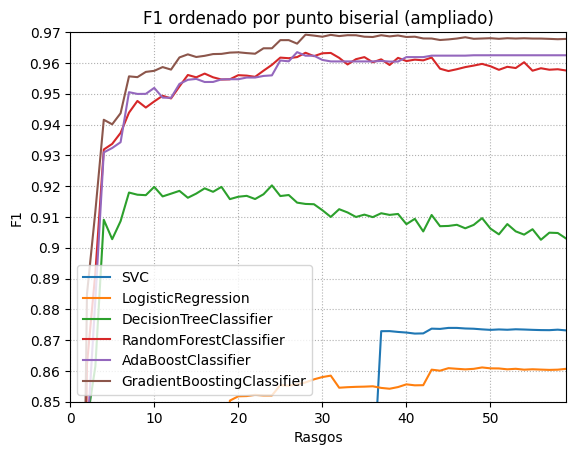

In [ ]:
coef = "point biserial correlation"
models = (svm.SVC(), LogisticRegression(), tree.DecisionTreeClassifier(), ensemble.RandomForestClassifier(), ensemble.AdaBoostClassifier(), ensemble.GradientBoostingClassifier())
averages = []
for model in models:
  excel_df = pd.read_excel(f"/content/drive/MyDrive/Colab Notebooks/Python/TFG/{coef}/{type(model).__name__}.xlsx", index_col=0)
  averages.append(excel_df.loc['Average'].to_numpy())
plotNormalMultiGraph(np.arange(0, len(averages[0])), averages, labels=[type(i).__name__ for i in models], title="F1 ordenado por punto biserial (ampliado)", ylim_bot=0.85)

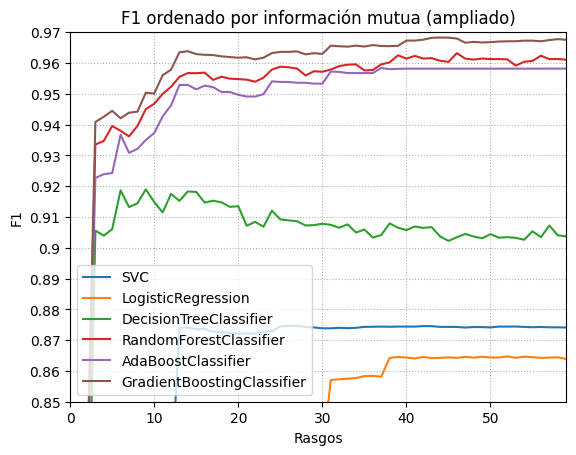

In [ ]:
coef = "mutual info"
models = (svm.SVC(), LogisticRegression(), tree.DecisionTreeClassifier(), ensemble.RandomForestClassifier(), ensemble.AdaBoostClassifier(), ensemble.GradientBoostingClassifier())
averages = []
for model in models:
  excel_df = pd.read_excel(f"/content/drive/MyDrive/Colab Notebooks/Python/TFG/{coef}/{type(model).__name__}.xlsx", index_col=0)
  averages.append(excel_df.loc['Average'].to_numpy())
plotNormalMultiGraph(np.arange(0, len(averages[0])), averages, labels=[type(i).__name__ for i in models], title="F1 ordenado por información mutua (ampliado)", ylim_bot=0.85)

In [ ]:
# Testing what seems to be the optimal set of features in the most consistent order with the best performing algorithm
order_by_coefficient = "point biserial correlation"
feature_cols = correlations.sort_values(by=order_by_coefficient ,key=lambda v: abs(v), ascending=False)[order_by_coefficient].index
final_model_f1_gpt = []
final_model_recall_gpt = []
final_model_prec_gpt = []
final_model_f1_human = []
final_model_recall_human = []
final_model_prec_human = []
final_model_acc = []
nfeatures = 29
iterations = 300
for i in range(iterations):
  df = df.sample(frac=1).reset_index(drop=True) # Shuffles the dataframe

  # DataFrames containing the stratified data (label 1 for AI generated and label 0 got human generated texts)
  df_gpt = df[df["label"] == 1]
  df_human = df[df["label"] == 0]
  final_model = ensemble.GradientBoostingClassifier()
  x_train = np.array(df_gpt[feature_cols[:nfeatures]][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human[feature_cols[:nfeatures]][:int(0.7*len(df_human))].to_numpy().tolist())
  y_train = np.array(df_gpt["label"][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human["label"][:int(0.7*len(df_human))].to_numpy().tolist())
  x_test  = np.array(df_gpt[feature_cols[:nfeatures]][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human[feature_cols[:nfeatures]][int(0.7*len(df_human)):].to_numpy().tolist())
  y_test  = np.array(df_gpt["label"][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human["label"][int(0.7*len(df_human)):].to_numpy().tolist())
  final_model.fit(x_train, y_train)
  y_prediction = final_model.predict(x_test)
  results_gpt = comparePredict(y_prediction, y_test, False)
  results_human = comparePredict([0 if i == 1 else 1 for i in y_prediction], [0 if i == 1 else 1 for i in y_test], False)
  final_model_f1_gpt.append(results_gpt["f1"])
  final_model_recall_gpt.append(results_gpt["recall"])
  final_model_prec_gpt.append(results_gpt["precision"])
  final_model_f1_human.append(results_human["f1"])
  final_model_recall_human.append(results_human["recall"])
  final_model_prec_human.append(results_human["precision"])
  final_model_acc.append(results_gpt["accuracy"])


print(f"Average F1 score for gpt reviews out of {iterations} samples of the {type(final_model).__name__} using {nfeatures} features: {sum(final_model_f1_gpt)/len(final_model_f1_gpt)}")
print("recall: ", sum(final_model_recall_gpt)/len(final_model_recall_gpt))
print("precision: ", sum(final_model_prec_gpt)/len(final_model_prec_gpt))
print(f"Average F1 score for gpt reviews out of {iterations} samples of the {type(final_model).__name__} using {nfeatures} features: {sum(final_model_f1_human)/len(final_model_f1_human)}")
print("recall: ", sum(final_model_recall_human)/len(final_model_recall_human))
print("precision: ", sum(final_model_prec_human)/len(final_model_prec_human))
print("General average accuracy", sum(final_model_acc)/len(final_model_acc))

Average F1 score for gpt reviews out of 300 samples of the GradientBoostingClassifier using 29 features: 0.966669408128794
recall:  0.971484375
precision:  0.9621232266686021
Average F1 score for gpt reviews out of 300 samples of the GradientBoostingClassifier using 29 features: 0.9950534424366161
recall:  0.9943202764976926
precision:  0.9957928359006125
General average accuracy 0.9913855421686717


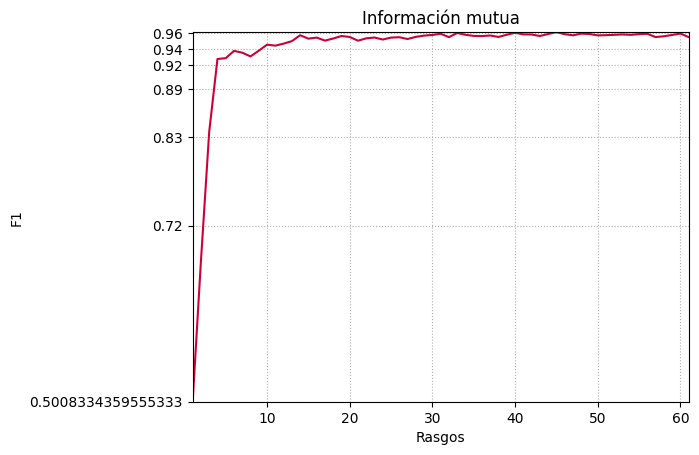

In [ ]:
# Plotting the average F1 given the number of features in mutual info order
order_by_coefficient = "mutual info"
feature_cols = correlations.sort_values(by=order_by_coefficient ,key=lambda v: abs(v), ascending=False)[order_by_coefficient].index
f1_dict_mi = {}
iterations = 40
for j in range(iterations):
  for i in range(len(feature_cols)):
    df = df.sample(frac=1).reset_index(drop=True) # Shuffles the dataframe

    # DataFrames containing the stratified data (label 1 for AI generated and label 0 got human generated texts)
    df_gpt = df[df["label"] == 1]
    df_human = df[df["label"] == 0]
    final_model = ensemble.RandomForestClassifier()
    x_train = np.array(df_gpt[feature_cols[:len(feature_cols)-i]][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human[feature_cols[:len(feature_cols)-i]][:int(0.7*len(df_human))].to_numpy().tolist())
    y_train = np.array(df_gpt["label"][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human["label"][:int(0.7*len(df_human))].to_numpy().tolist())
    x_test  = np.array(df_gpt[feature_cols[:len(feature_cols)-i]][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human[feature_cols[:len(feature_cols)-i]][int(0.7*len(df_human)):].to_numpy().tolist())
    y_test  = np.array(df_gpt["label"][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human["label"][int(0.7*len(df_human)):].to_numpy().tolist())
    final_model.fit(x_train, y_train)
    y_prediction = final_model.predict(x_test)
    if len(feature_cols[:len(feature_cols)-i]) in f1_dict_mi.keys():
      f1_dict_mi[len(feature_cols[:len(feature_cols)-i])].append(comparePredict(y_prediction, y_test, False)["f1"])
    else:
      f1_dict_mi[len(feature_cols[:len(feature_cols)-i])] = [comparePredict(y_prediction, y_test, False)["f1"]]
for k in f1_dict_mi.keys():
  f1_dict_mi[k] = sum(f1_dict_mi[k])/iterations
plotGraph(f1_dict_mi.keys(), f1_dict_mi.values(), "Información mutua", nticks=7)

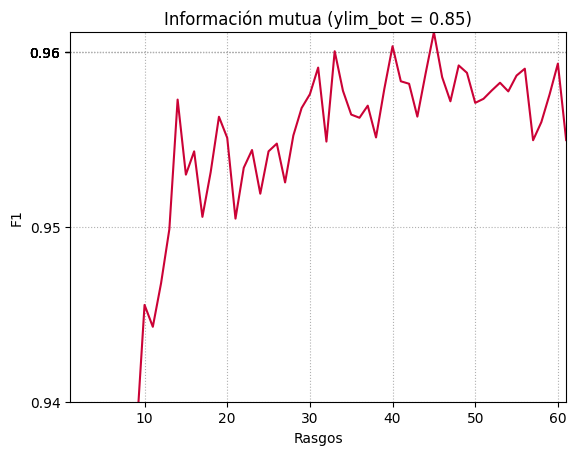

Standard deviation of values over 0.94 is  0.0035759937713230583
Average:  0.9557088168328989


In [ ]:
# Plotting the average F1 given the number of features in mutual info order but zooming to the upper bound
plotGraph(f1_dict_mi.keys(), f1_dict_mi.values(), "Información mutua (ylim_bot = 0.85)", nticks=7, ylim_bot=0.94)
print("Standard deviation of values over 0.94 is ", np.std([i for i in f1_dict_mi.values() if i >= 0.94]))
print("Average: ", np.average([i for i in f1_dict_mi.values() if i >= 0.94]))

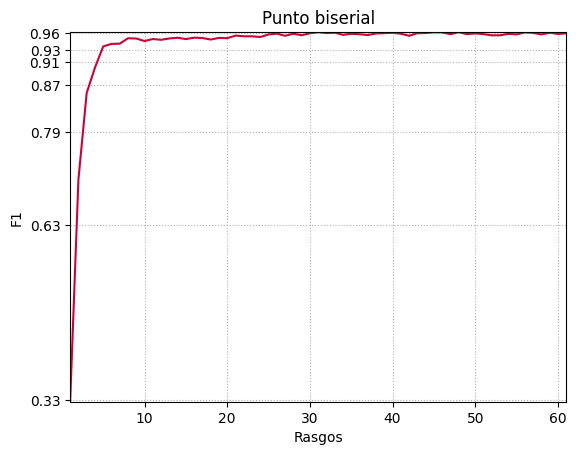

In [ ]:
# Plotting the average F1 given the number of features in point biserial order
order_by_coefficient = "point biserial correlation"
feature_cols = correlations.sort_values(by=order_by_coefficient ,key=lambda v: abs(v), ascending=False)[order_by_coefficient].index
f1_dict = {}
iterations = 40
for j in range(iterations):
  for i in range(len(feature_cols)):
    df = df.sample(frac=1).reset_index(drop=True) # Shuffles the dataframe

    # DataFrames containing the stratified data (label 1 for AI generated and label 0 got human generated texts)
    df_gpt = df[df["label"] == 1]
    df_human = df[df["label"] == 0]
    final_model = ensemble.RandomForestClassifier()
    x_train = np.array(df_gpt[feature_cols[:len(feature_cols)-i]][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human[feature_cols[:len(feature_cols)-i]][:int(0.7*len(df_human))].to_numpy().tolist())
    y_train = np.array(df_gpt["label"][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human["label"][:int(0.7*len(df_human))].to_numpy().tolist())
    x_test  = np.array(df_gpt[feature_cols[:len(feature_cols)-i]][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human[feature_cols[:len(feature_cols)-i]][int(0.7*len(df_human)):].to_numpy().tolist())
    y_test  = np.array(df_gpt["label"][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human["label"][int(0.7*len(df_human)):].to_numpy().tolist())
    final_model.fit(x_train, y_train)
    y_prediction = final_model.predict(x_test)
    if len(feature_cols[:len(feature_cols)-i]) in f1_dict.keys():
      f1_dict[len(feature_cols[:len(feature_cols)-i])].append(comparePredict(y_prediction, y_test, False)["f1"])
    else:
      f1_dict[len(feature_cols[:len(feature_cols)-i])] = [comparePredict(y_prediction, y_test, False)["f1"]]
for k in f1_dict.keys():
  f1_dict[k] = sum(f1_dict[k])/iterations
plotGraph(f1_dict.keys(), f1_dict.values(), "Punto biserial", nticks=7)

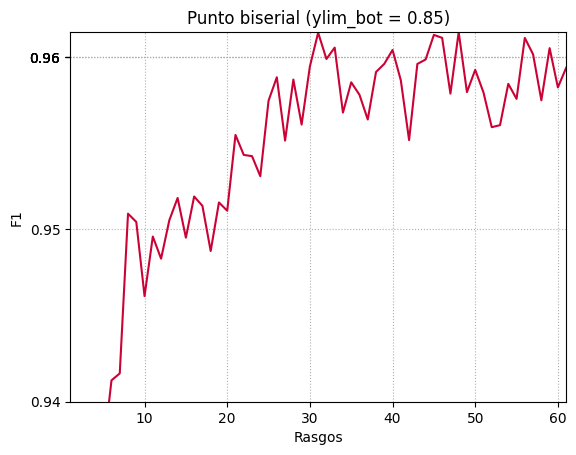

Standard deviation of values over 0.94 is  0.004807633386817659
Average:  0.9557708552767438


In [ ]:
# Plotting the average F1 given the number of features in point biserial order but zooming to the upper bound
plotGraph(f1_dict.keys(), f1_dict.values(), "Punto biserial (ylim_bot = 0.85)", ylim_bot=0.94)
print("Standard deviation of values over 0.94 is ", np.std([i for i in f1_dict.values() if i >= 0.94]))
print("Average: ", np.average([i for i in f1_dict.values() if i >= 0.94]))